In [4]:
import nltk
#nltk.download()
from nltk import pos_tag, word_tokenize,sent_tokenize,corpus
from collections import Counter
from collections import defaultdict
from operator import itemgetter
from collections import OrderedDict
import numpy
import pandas
#from matplotlib import *
#from pylab import *
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet as wn
from gensim.models import word2vec,phrases
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#%matplotlib inline

In [19]:
from nltk.corpus import PlaintextCorpusReader
#corpus_root=r"C:\Users\tihor\OneDrive\Documents\Python Scripts\TextParsing\FOMC"
corpus_root=r"d:\TextParsing\FOMC"
fed=PlaintextCorpusReader(corpus_root, '.*')
len(fed.fileids())

64

In [20]:
def isNoun(tag):
    return tag in ['NN','NNS','NNP','NNPS']
def isAdjective(tag):
    return tag in ['JJ','JJR','JJS']
def isVerb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def isAdverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def penn_to_wn(tag):
    if isAdjective(tag):
        return wn.ADJ
    elif isNoun(tag):
        return wn.NOUN
    elif isAdverb(tag):
        return wn.ADV
    elif isVerb(tag):
        return wn.VERB
    return None

In [21]:
def GetCollocations(text):
    collocations=[]
    tokens=word_tokenize(text)
    pos_tokens=pos_tag(tokens)
    for i in range(0,len(pos_tokens)):
        if isNoun(pos_tokens[i][1]) or isAdjective(pos_tokens[i][1]):
            if isNoun(pos_tokens[i+1][1]) or isAdjective(pos_tokens[i+1][1]):
                if isNoun(pos_tokens[i+2][1]):
                    if(isNoun(pos_tokens[i+3][1])):
                        collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0]+" "+pos_tokens[i+2][0]+" "+pos_tokens[i+3][0])
                    else:
                        collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0]+" "+pos_tokens[i+2][0])
                else:
                    collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0])
            elif pos_tokens[i+1][1]=='IN':
                if isNoun(pos_tokens[i+2][1]):
                    collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0]+" "+pos_tokens[i+2][0])
    return collocations

In [22]:
collocation_count=defaultdict(int)
for fileid in fed.fileids():
    collocations=GetCollocations(fed.raw(corpus_root+"/"+fileid))
    for item in collocations:
        collocation_count[item]=collocation_count.get(item,0)+1

In [23]:
sorted_count = OrderedDict(sorted(collocation_count.items(),key=lambda x:x[1],reverse=True))
sorted_count_no_duplicates=OrderedDict()
itemtoremove={}
for item1 in sorted_count:
    for item2 in sorted_count:
        if item1.find(item2)!=-1 and sorted_count[item1]==sorted_count[item2] and item1!=item2:
                itemtoremove[item2]=sorted_count[item2]
for item in sorted_count:
    if item not in itemtoremove.keys():
        sorted_count_no_duplicates[item]=sorted_count[item]

In [24]:
phrases=[]
for item in sorted_count_no_duplicates:
    if sorted_count_no_duplicates[item]>=len(fed.fileids()):
        print(item+"\t"+str(sorted_count_no_duplicates[item]))
        phrases.append(item.lower())

federal funds rate	243
market conditions	164
maximum employment	159
labor market conditions	152
inflation expectations	149
target range	140
agency mortgage-backed securities	128
price stability	125
economic activity	110
labor market	100
unemployment rate	88
economic conditions	77
monetary policy	76
longer-term inflation expectations	71
dual mandate	71
Treasury securities	68
economic outlook	68
Federal Open Market Committee	64
statutory mandate	64
FOMC monetary policy action	64
Vice Chairman	64


In [25]:
len(sorted_count_no_duplicates)

524

In [26]:
sentences=nltk.sent_tokenize(fed.raw('FOMCStatement-20140618.txt'))
tokenized_sentences=[nltk.word_tokenize(sentence) for sentence in sentences]
tagged_sentences=[nltk.pos_tag(sentence) for sentence in tokenized_sentences]
chunked_sentences=nltk.ne_chunk_sents(tagged_sentences,binary=True)

In [27]:
def extract_entity_names(t):
    entity_names=[]
    if hasattr(t,'label') and t.label:
        if t.label=='NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))
    return entity_names

entity_names=[]
for tree in chunked_sentences:
    entity_names.extend(extract_entity_names(tree))

print(entity_names)

[]


In [28]:
def getPhraseCount(text,phrases):
    text=text.lower()
    count=[0 for phrase in phrases]
    pos=[0 for phrase in phrases]
    length=[len(phrase) for phrase in phrases]
    for phrase in phrases:
        list_index=phrases.index(phrase)
        while pos[list_index]<len(text):
            pos[list_index]=text.find(phrase,pos[list_index])
            if pos[list_index]>-1:
                count[list_index]=count[list_index]+1
                pos[list_index]=pos[list_index]+length[list_index]
            else:
                break
    return count

In [32]:
#phrases=['inflation','federal funds rate','maximum employment','agency mortgage-backed securities','price stability',
#         'inflation expectations','target range','labor market conditions','unemployment rate','economic activity',
#         'longer-term inflation expectations','dual mandate','economic recovery']
summary={}
for f in fed.fileids():
    rowName=f[f.find("-")+1:]
    rowName=rowName[:rowName.find(".txt")]
    summary[rowName]=getPhraseCount(fed.raw(f),phrases)
df=pandas.DataFrame(summary)
df=pandas.DataFrame(df.transpose())
df.columns=phrases
df.to_csv('temp.csv')
df

,federal funds rate,market conditions,maximum employment,labor market conditions,inflation expectations,target range,agency mortgage-backed securities,price stability,economic activity,labor market,...,economic conditions,monetary policy,longer-term inflation expectations,dual mandate,treasury securities,economic outlook,federal open market committee,statutory mandate,fomc monetary policy action,vice chairman
20110126,2,1,2,1,2,1,0,3,0,1,...,1,1,1,1,1,1,1,1,1,1
20110315,2,0,2,0,3,1,0,3,0,1,...,1,1,1,1,1,1,1,1,1,1
20110427,2,0,2,0,3,1,0,3,0,1,...,1,1,1,1,1,1,1,1,1,1
20110622,2,0,2,0,2,1,0,2,0,1,...,1,1,1,2,1,1,1,1,1,1
20110809,3,1,1,1,2,1,0,2,1,1,...,2,1,1,2,0,2,1,1,1,1
20110921,2,1,1,1,2,1,2,2,0,1,...,1,1,1,3,3,2,1,1,1,1
20111102,2,1,1,1,2,1,2,2,0,1,...,1,1,1,3,1,2,1,1,1,1
20111213,2,1,1,1,2,1,2,2,0,1,...,1,1,1,3,1,2,1,1,1,1
20120125,3,1,1,1,1,1,2,2,0,1,...,2,2,1,3,1,1,1,1,1,1
20120313,3,1,1,1,1,1,2,2,0,1,...,2,2,1,3,1,1,1,1,1,1


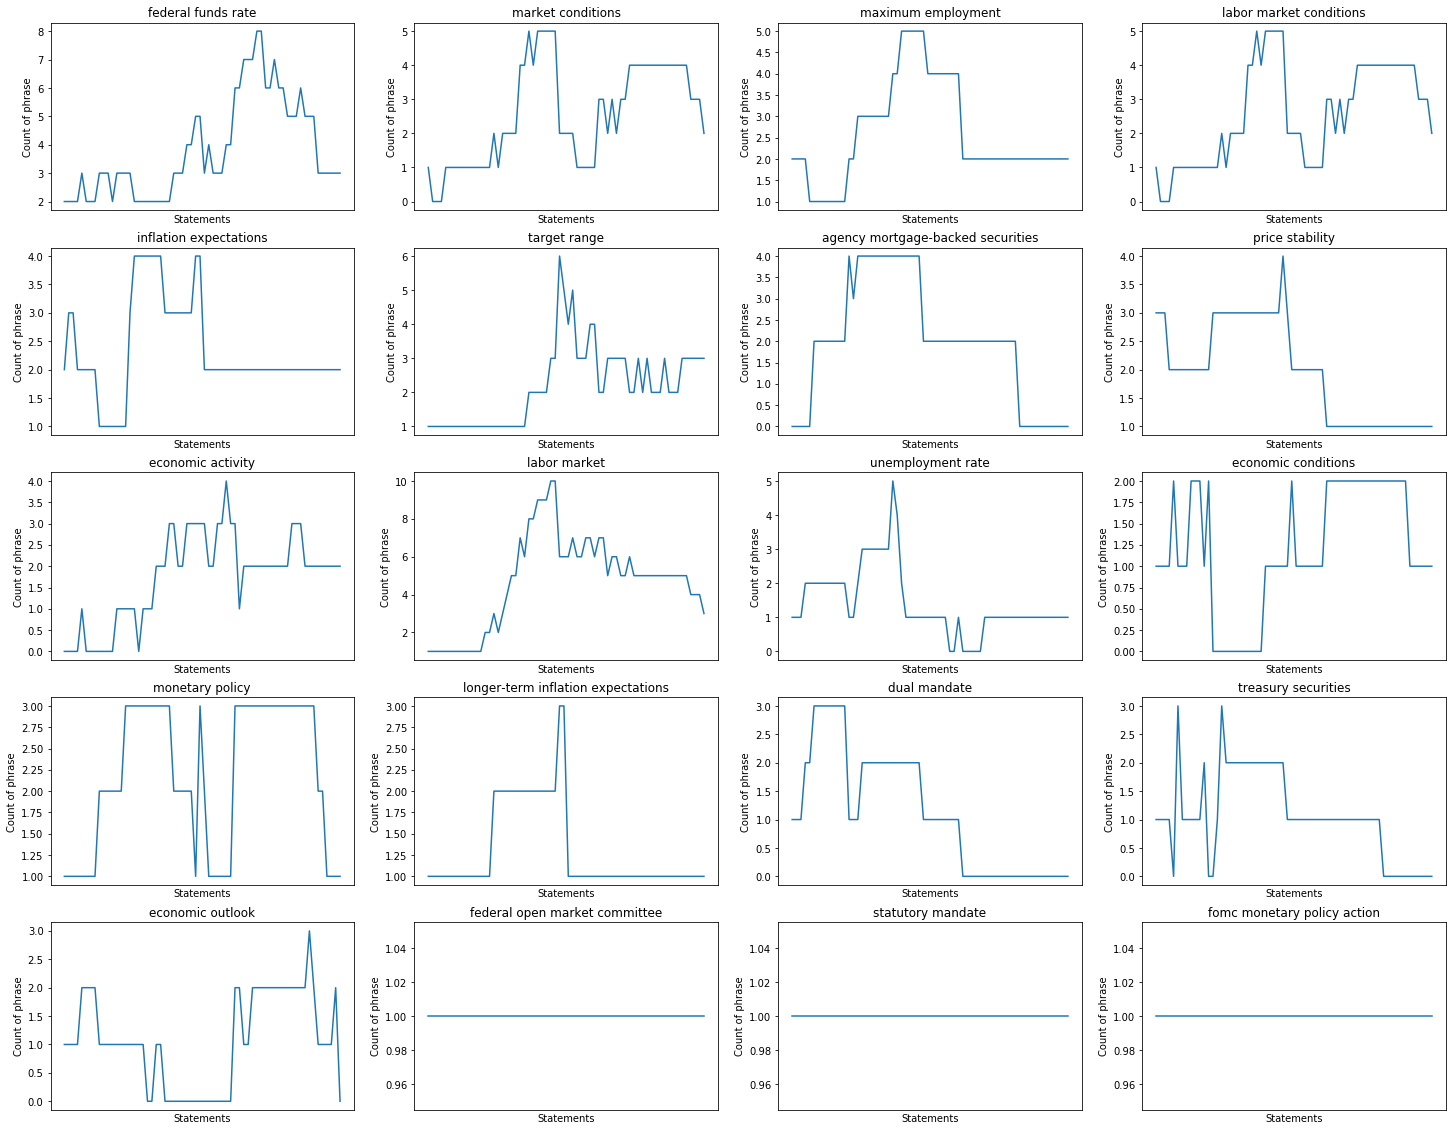

In [31]:
plt.figure(0, figsize=(25,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(df[phrases[i]])
    plt.xlabel("Statements")
    plt.ylabel("Count of phrase")
    plt.gca().get_xaxis().set_ticks([])
    plt.title(phrases[i])
plt.show()

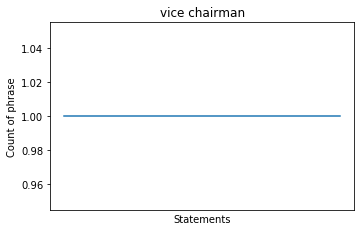

In [15]:
plt.figure(0, figsize=(25,20))
for i in range(20,len(phrases)):
    plt.subplot(5,4,i+1-20)
    plt.plot(df[phrases[i]])
    plt.xlabel("Statements")
    plt.ylabel("Count of phrase")
    plt.gca().get_xaxis().set_ticks([])
    
    plt.title(phrases[i])
plt.show()

In [16]:
STOP_WORDS=corpus.stopwords.words()
STOP_WORDS.append(",")
STOP_WORDS.append(".")
STOP_WORDS.append(";")
STOP_WORDS.append("$")
STOP_WORDS.append("0")
STOP_WORDS.append("1/2")
STOP_WORDS.append("1/4")
STOP_WORDS.append("2")
STOP_WORDS.append("40")
STOP_WORDS.append("6-1/2")
STOP_WORDS.append(":")
STOP_WORDS.append("a.")
STOP_WORDS.append("'s")
STOP_WORDS.append("--")
phrases_amended=[]
for phrase in phrases:
    phrase_amended=phrase.replace(" ","_")
    phrases_amended.append(phrase_amended)

In [17]:
statements=[]
for fileid in fed.fileids():
    statement=fed.raw(fileid)
    sentences=sent_tokenize(statement)
    for sentence in sentences:
        sentence_lower=sentence.lower()
        for i,val in enumerate(phrases):
            sentence_lower=sentence_lower.replace(phrases[i],phrases_amended[i])
        tokenized_sentence=word_tokenize(sentence_lower)
        pos_tokens=pos_tag(tokenized_sentence)
        
        #print(tokenized_sentence)
        clean_sentence=[]
        for item in pos_tokens:
            word=item[0]
            pos=penn_to_wn(item[1])
            #print(word,pos)
            if word.lower() not in STOP_WORDS:
                if pos is None:
                    clean_sentence.append(wordnet_lemmatizer.lemmatize(word.lower()))
                else:
                    clean_sentence.append(wordnet_lemmatizer.lemmatize(word.lower(),pos))
        statements.append(clean_sentence)
len(statements)

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  Searched in:
    - 'C:\\Users\\tihor/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'c:\\users\\tihor\\appdata\\local\\programs\\python\\python36\\nltk_data'
    - 'c:\\users\\tihor\\appdata\\local\\programs\\python\\python36\\lib\\nltk_data'
    - 'C:\\Users\\tihor\\AppData\\Roaming\\nltk_data'
**********************************************************************


In [194]:
statements[0:5]

[['information',
  'receive',
  'since',
  'federal_open_market_committee',
  'december',
  'confirms',
  'economic',
  'recovery',
  'continue',
  'though',
  'rate',
  'insufficient',
  'bring',
  'significant',
  'improvement',
  'labor_market_conditions'],
 ['growth',
  'household',
  'spending',
  'pick',
  'late',
  'last',
  'year',
  'remains',
  'constrain',
  'high',
  'unemployment',
  'modest',
  'income',
  'growth',
  'low',
  'housing',
  'wealth',
  'tight',
  'credit'],
 ['business',
  'spending',
  'equipment',
  'software',
  'rise',
  'investment',
  'nonresidential',
  'structure',
  'still',
  'weak'],
 ['employer', 'remain', 'reluctant', 'add', 'payroll'],
 ['housing', 'sector', 'continue', 'depress']]

In [210]:
model = word2vec.Word2Vec(statements, size=20, window=20, min_count=len(fed.fileids())*1.5, workers=4)
model.wv.vocab

{'accommodative': <gensim.models.keyedvectors.Vocab at 0x28904239780>,
 'action': <gensim.models.keyedvectors.Vocab at 0x28904239ba8>,
 'agency_mortgage-backed_securities': <gensim.models.keyedvectors.Vocab at 0x289041b1ef0>,
 'anticipate': <gensim.models.keyedvectors.Vocab at 0x28904239cc0>,
 'appropriate': <gensim.models.keyedvectors.Vocab at 0x28904239a58>,
 'committee': <gensim.models.keyedvectors.Vocab at 0x28903108f60>,
 'consistent': <gensim.models.keyedvectors.Vocab at 0x28904239710>,
 'continue': <gensim.models.keyedvectors.Vocab at 0x289042399b0>,
 'decide': <gensim.models.keyedvectors.Vocab at 0x28904239a20>,
 'decline': <gensim.models.keyedvectors.Vocab at 0x289042398d0>,
 'economic': <gensim.models.keyedvectors.Vocab at 0x289030a5da0>,
 'economic_activity': <gensim.models.keyedvectors.Vocab at 0x289030b2d68>,
 'expect': <gensim.models.keyedvectors.Vocab at 0x289042394e0>,
 'federal_funds_rate': <gensim.models.keyedvectors.Vocab at 0x289041abfd0>,
 'financial': <gensim.mode

In [211]:
model.wv['inflation']

array([-1.10126126,  0.41414818,  0.58926922,  0.04541207, -0.79492819,
        0.0762899 , -0.0551094 , -0.2546322 ,  0.18118747,  0.14591101,
        0.099741  ,  0.18315263, -0.54060233,  0.31320211,  0.03755588,
       -0.19580457,  0.82066363, -0.0782019 , -0.28936753,  0.01736294], dtype=float32)

In [212]:
model.most_similar('inflation')

[('longer-term', 0.9990987181663513),
 ('purchase', 0.998883843421936),
 ('accommodative', 0.9988819360733032),
 ('percent', 0.9988025426864624),
 ('low', 0.9987268447875977),
 ('toward', 0.998688280582428),
 ('unemployment_rate', 0.9986644387245178),
 ('committee', 0.9986615180969238),
 ('inflation_expectations', 0.9985589981079102),
 ('economic', 0.9984915256500244)]

In [213]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

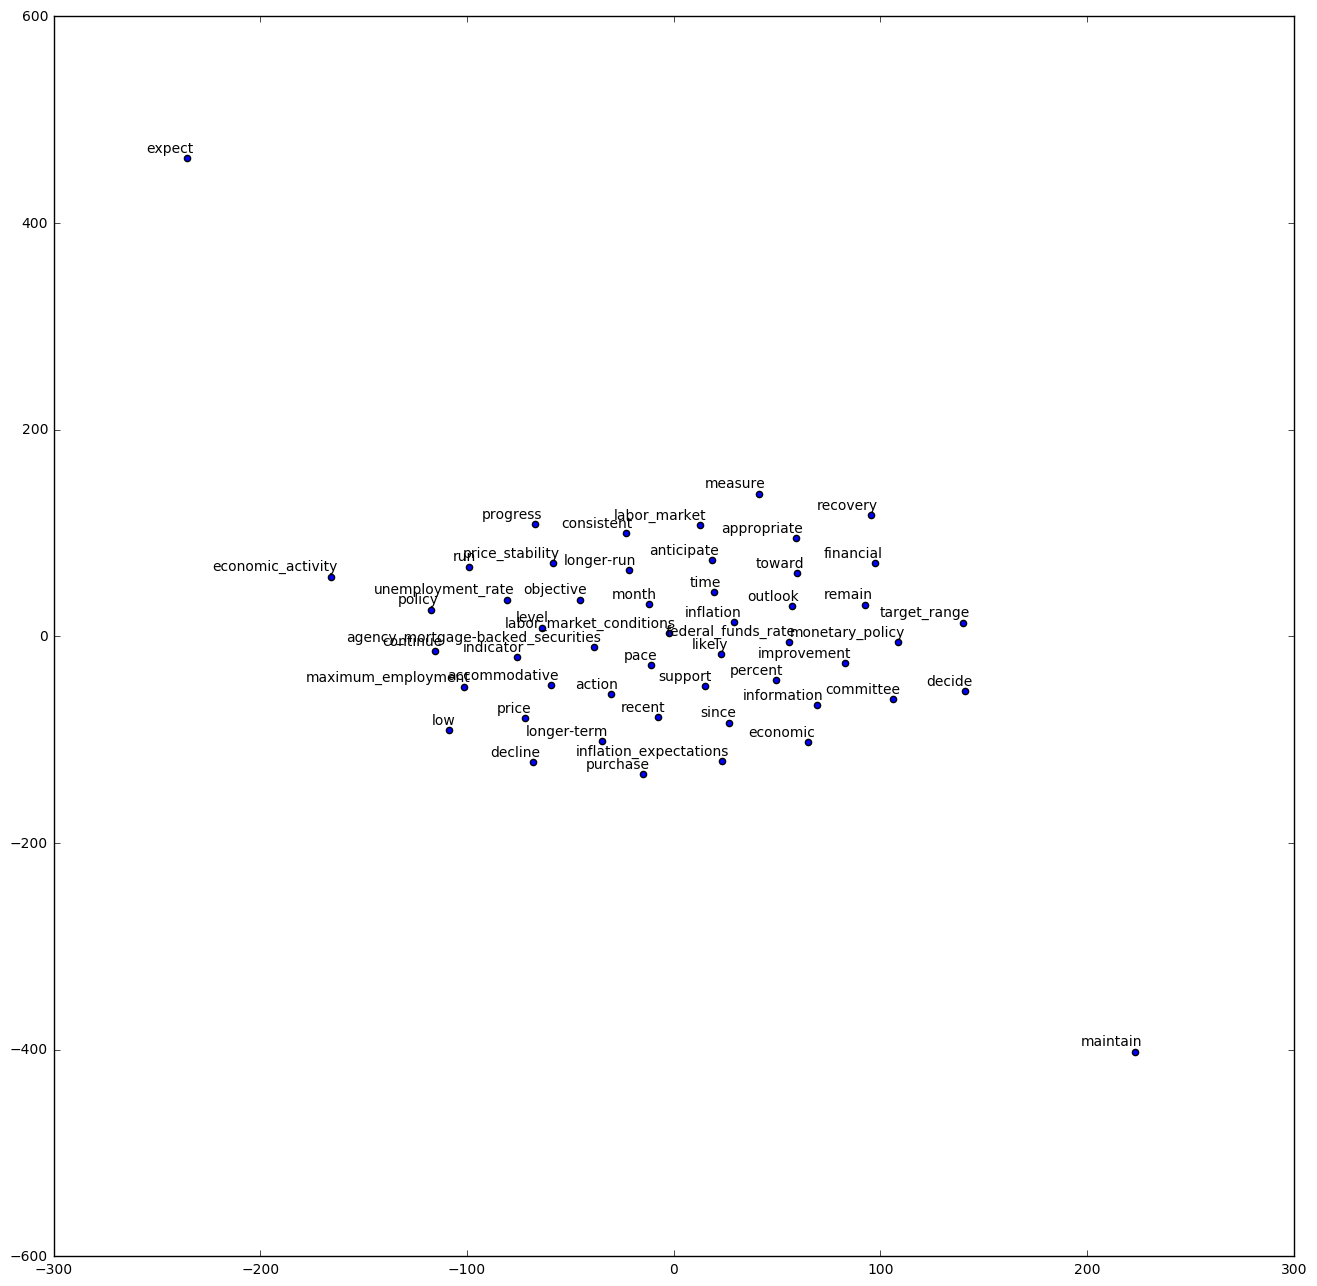

In [214]:
tsne_plot(model)

In [226]:
statements=[]
for fileid in fed.fileids():
    statement=fed.raw(fileid)
    sentences=sent_tokenize(statement)
    for sentence in sentences:
        sentence_lower=sentence.lower()
        tokenized_sentence=word_tokenize(sentence_lower)
        statements.append(tokenized_sentence)
print(len(statements))
bigram_transformer = Phrases(statements)
bigram = Phraser(phrases)

1030


NameError: name 'Phraser' is not defined

In [228]:
bigram_transformer